## Face and Facial Keypoint detection

After you've trained a neural network to detect facial keypoints, you can then apply this network to *any* image that includes faces. The neural network expects a Tensor of a certain size as input and, so, to detect any face, you'll first have to do some pre-processing.

1. Detect all the faces in an image using a face detector (we'll be using a Haar Cascade detector in this notebook).
2. Pre-process those face images so that they are grayscale, and transformed to a Tensor of the input size that your net expects. This step will be similar to the `data_transform` you created and applied in Notebook 2, whose job was tp rescale, normalize, and turn any iimage into a Tensor to be accepted as input to your CNN.
3. Use your trained model to detect facial keypoints on the image.

---

In the next python cell we load in required libraries for this section of the project.

In [1]:
import cv2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

#### Select an image 

Select an image to perform facial keypoint detection on; you can select any image of faces in the `images/` directory.

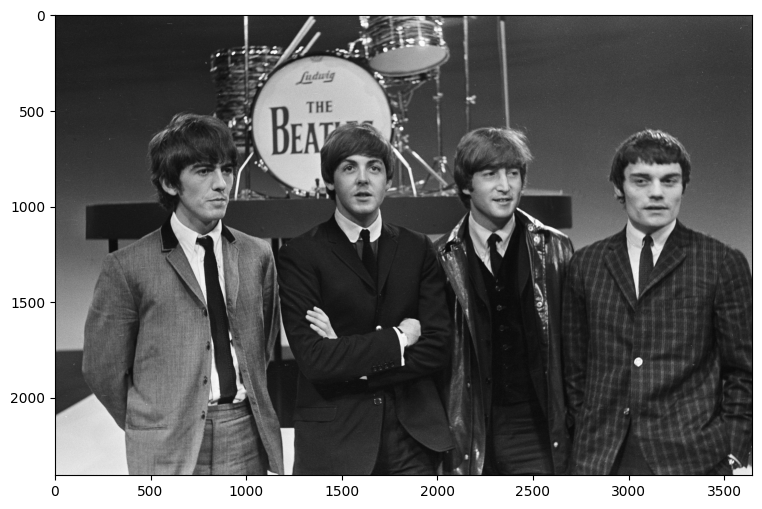

In [3]:
import cv2
# load in color image for face detection
#image = cv2.imread('images/obamas.jpg')
#image = cv2.imread('images/mona_lisa.jpg')
image = cv2.imread('images/the_beatles.jpg')

# switch red and blue color channels 
# --> by default OpenCV assumes BLUE comes first, not RED as in many images
image_RGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_gray=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# plot the image
fig = plt.figure(figsize=(9,9))
plt.imshow(image_RGB)

## Detect all faces in an image

Next, you'll use one of OpenCV's pre-trained Haar Cascade classifiers, all of which can be found in the `detector_architectures/` directory, to find any faces in your selected image.

In the code below, we loop over each face in the original image and draw a red square on each face (in a copy of the original image, so as not to modify the original). You can even [add eye detections](https://docs.opencv.org/3.4.1/d7/d8b/tutorial_py_face_detection.html) as an *optional* exercise in using Haar detectors.

An example of face detection on a variety of images is shown below.

<img src='images/haar_cascade_ex.png' width=80% height=80%/>


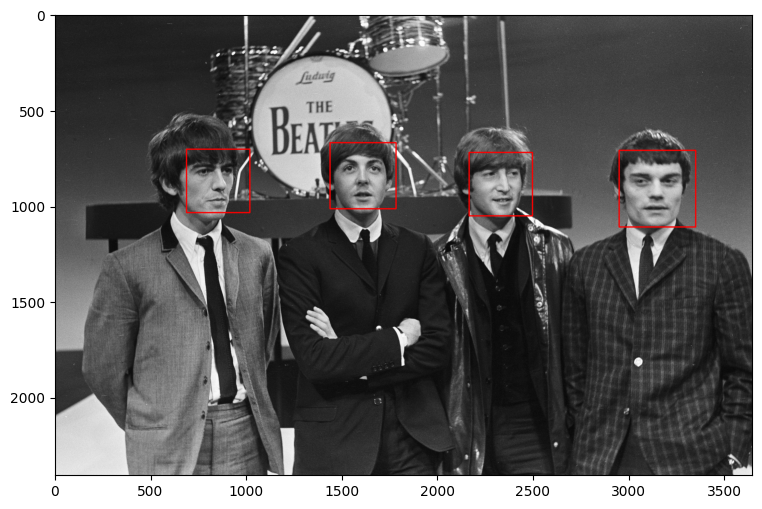

In [4]:
# load in a haar cascade classifier for detecting frontal faces
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')
#face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_mcs_nose.xml')
#face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_smile.xml')
eye_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_eye.xml')
# run the detector
# the output here is an array of detections; the corners of each detection box
# if necessary, modify these parameters until you successfully identify every face in a given image
# faces = face_cascade.detectMultiScale(image, 1.2, 2)
#faces = face_cascade.detectMultiScale(image, 1.2, 2) # color
faces = face_cascade.detectMultiScale(image, scaleFactor=1.3, minNeighbors=5, minSize=(200, 200))


# make a copy of the original image to plot detections on
#image_with_detections = image.copy()
image_with_detections = image_RGB.copy()

#print(faces.shape)
# loop over the detected faces, mark the image where each face is found
for (x,y,w,h) in faces:
    # print(w)
    # draw a rectangle around each detected face
    # you may also need to change the width of the rectangle drawn depending on image resolution
    cv2.rectangle(image_with_detections,(x,y),(x+w,y+h),(255,0,0),5) 
    roi_gray = image_gray[y:y+h, x:x+w]
    roi_color = image_RGB[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_color)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),5)
fig = plt.figure(figsize=(9,9))

plt.imshow(image_with_detections)

In [5]:
#i=1
#print(type(faces))
#for (x,y,w,h) in faces:
#    #print(type(x))
#    print(i)
#    i+=1

## Loading in a trained model

Once you have an image to work with (and, again, you can select any image of faces in the `images/` directory), the next step is to pre-process that image and feed it into your CNN facial keypoint detector.

First, load your best model by its filename.

In [116]:
import torch
from models import OptimizedNet

net = OptimizedNet()

## TODO: load the best saved model parameters (by your path name)
## You'll need to un-comment the line below and add the correct name for *your* saved model
net.load_state_dict(torch.load('models/net-120.pt'))

## print out your net and prepare it for testing (uncomment the line below)
net.eval()

OptimizedNet(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReL

## Keypoint detection

Now, we'll loop over each detected face in an image (again!) only this time, you'll transform those faces in Tensors that your CNN can accept as input images.

### TODO: Transform each detected face into an input Tensor

You'll need to perform the following steps for each detected face:
1. Convert the face from RGB to grayscale
2. Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
3. Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
4. Reshape the numpy image into a torch image.

**Hint**: The sizes of faces detected by a Haar detector and the faces your network has been trained on are of different sizes. If you find that your model is generating keypoints that are too small for a given face, try adding some padding to the detected `roi` before giving it as input to your model.

You may find it useful to consult to transformation code in `data_load.py` to help you perform these processing steps.


### TODO: Detect and display the predicted keypoints

After each face has been appropriately converted into an input Tensor for your network to see as input, you can apply your `net` to each face. The ouput should be the predicted the facial keypoints. These keypoints will need to be "un-normalized" for display, and you may find it helpful to write a helper function like `show_keypoints`. You should end up with an image like the following with facial keypoints that closely match the facial features on each individual face:

<img src='images/michelle_detected.png' width=30% height=30%/>




In [117]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')

In [122]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(image_test, predicted_key_pts_test, gt_pts=None, batch_size=10):

  #  for i in range(batch_size):
        
    plt.figure(figsize=(20,10))
    image=image_test[0].data
    # un-transform the predicted key_pts data


    # un-transform the image data
    image = image.numpy()   # convert to numpy array from a Tensor
    print(image.shape)
    image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

    # un-transform the predicted key_pts data
    predicted_key_pts =predicted_key_pts_test[0].data
    predicted_key_pts = predicted_key_pts.numpy()
    # undo normalization of keypoints  
    predicted_key_pts = predicted_key_pts*0.025+100
        
    
    # call show_all_keypoints
    show_all_keypoints(np.squeeze(image), predicted_key_pts)      
    
    plt.show()

(1, 224, 224)


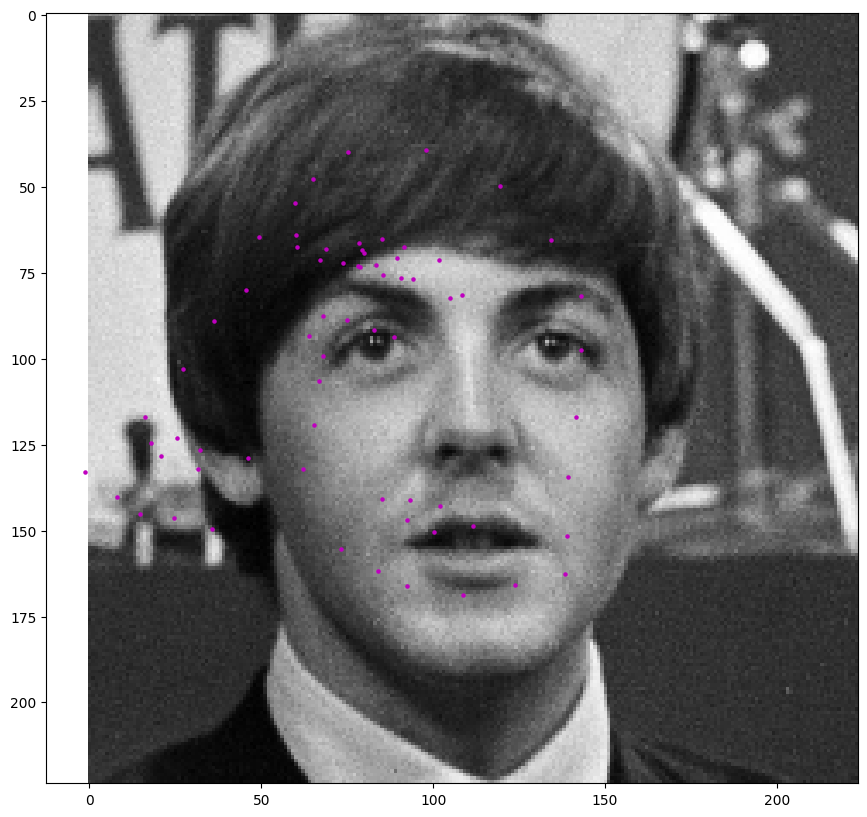

(1, 224, 224)


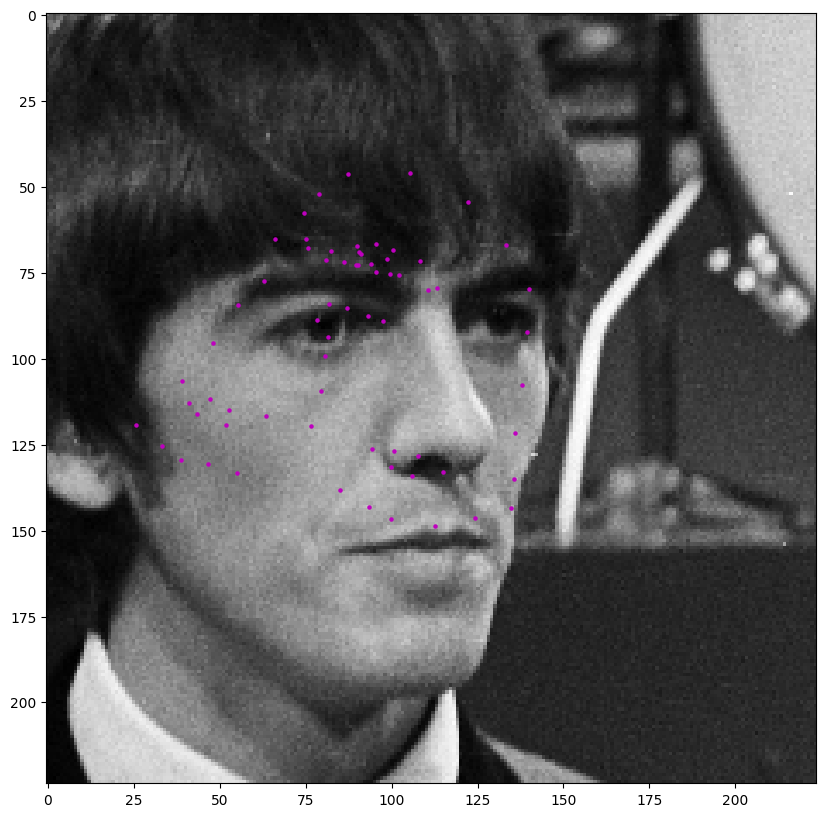

(1, 224, 224)


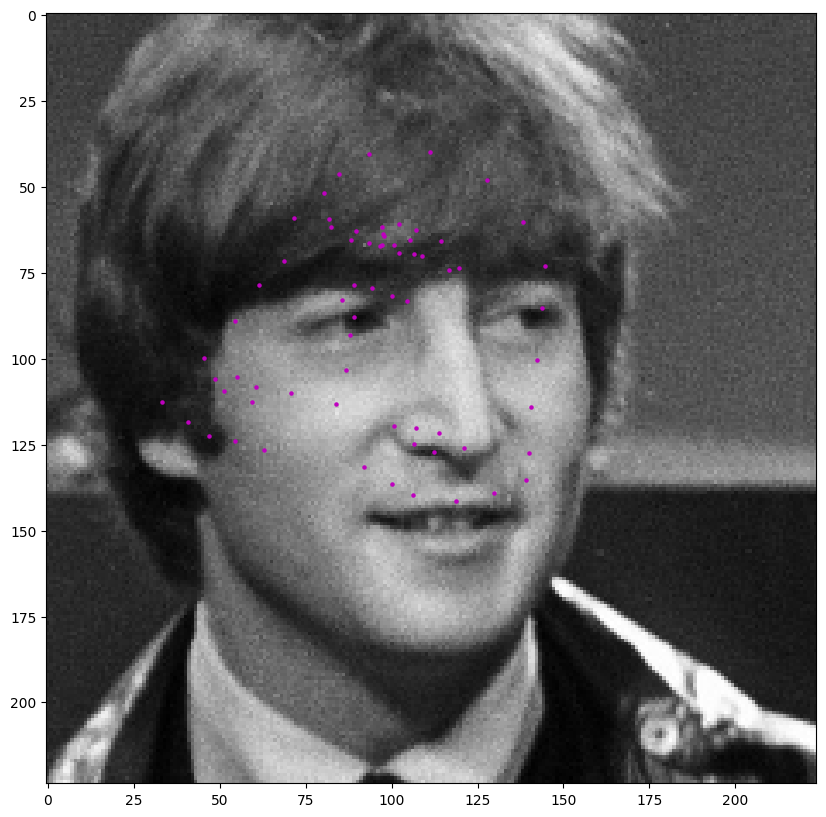

(1, 224, 224)


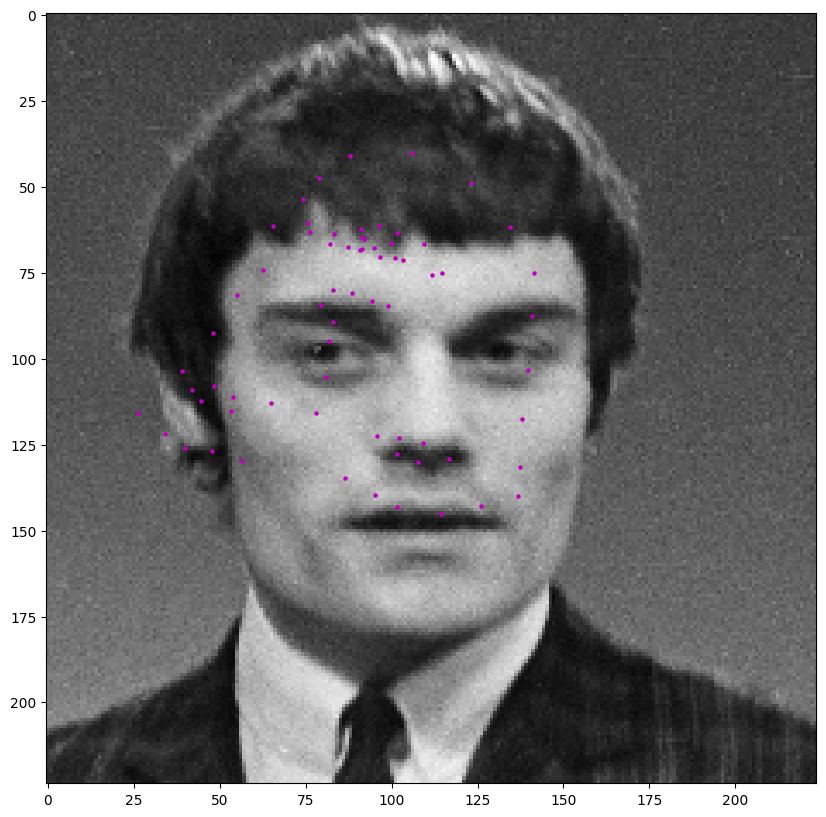

In [123]:
image_copy = np.copy(image)

# loop over the detected faces from your haar cascade
for (x,y,w,h) in faces:
    # Select the region of interest that is the face in the image 
    #roi = image_copy[y-100:y+h+100, x-100:x+w+100]
    margin = int(w*0.3) # you could need to change and to tune this value
    roi = image_copy[y-margin:y+h+margin, x-margin:x+w+margin]
    #roi = image_copy[y-100:y+h+100, x-100:x+w+100]
    ## TODO: Convert the face region from RGB to grayscale
    roi=cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)
    ## TODO: Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
    roi=roi/255.0
    ## TODO: Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
    new_w=224
    new_h=224
    roi = cv2.resize(roi, (new_w, new_h))
    ## TODO: Reshape the numpy image shape (H x W x C) into a torch image shape (C x H x W)
    # add that third color dim
    roi = roi.reshape(roi.shape[0], roi.shape[1], 1)
    roi = roi.transpose((2, 0, 1))
    roiT=torch.from_numpy(roi)
    #print(roiT.shape)
    ## TODO: Make facial keypoint predictions using your loaded, trained network
    roiT = roiT.type(torch.FloatTensor)
    #print(roiT.shape)
    roiT.unsqueeze_(0)
    #print(roiT.shape)
    output_pts = net(roiT)
    # reshape to batch_size x 68 x 2 pts
    output_pts = output_pts.view(output_pts.size()[0], 68, -1)
    ## TODO: Display each detected face and the corresponding keypoints        
    visualize_output(roiT, output_pts)